In [1]:
import pandas as pd
import numpy as np

In [2]:
! ls

analyse_ab_test.ipynb
discount_experiment_synthetic.csv
discount_experiment_synthetic_v2.csv
experiment_generate_synthetic_data.ipynb
iso_codes.txt
marathon_descriptive_example.ipynb
net_earnings_eu.tsv
population.tsv


In [183]:
df = pd.read_csv('discount_experiment_synthetic_v2.csv')
df['country_avg_annual_earning'] = df.country_avg_annual_earning/1000
before_df = df[df.period == '2024-01-01']
after_df = df[df.period == '2024-02-01']

before_df.shape[0], after_df.shape[0]

(205369, 256270)

### Power analysis

#### Classic approach

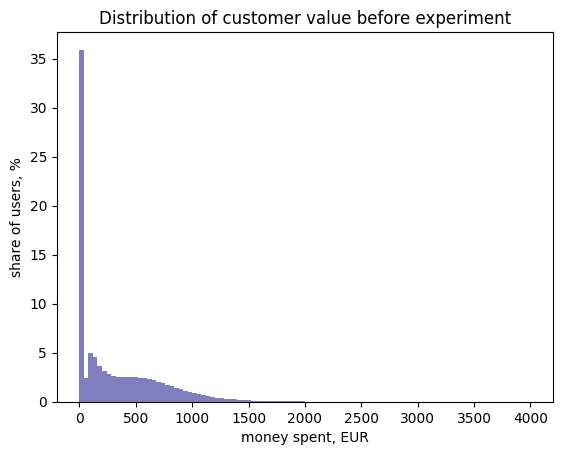

In [31]:
from matplotlib import pyplot

hist_range = [0, 4000]
hist_bins = 100

pyplot.hist(
    df[df.period == '2024-01-01'].customer_value.values,
    label = 'before',
    alpha = 0.5, range = hist_range, bins = hist_bins,
    color = 'navy',
    # calculating weights to get normalised histogram
    weights = np.ones_like(df[df.period == '2024-01-01'].index)*100/df[df.period == '2024-01-01'].shape[0]
)

# pyplot.hist(
#     df[df.period == '2024-02-01'].customer_value.values,
#     label = 'after',
#     alpha = 0.5, range = hist_range, bins = hist_bins,
#     color = 'red',
#     # calculating weights to get normalised histogram
#     weights = np.ones_like(df[df.period == '2024-02-01'].index)*100/df[df.period == '2024-02-01'].shape[0]
# )

# pyplot.legend(loc = 'upper right')
pyplot.title('Distribution of customer value before experiment')
pyplot.xlabel('money spent, EUR')
pyplot.ylabel('share of users, %')
pyplot.show()

In [4]:
before_df.retention.mean()

0.642075398039517

In [5]:
before_df.customer_value.mean()

326.6769713115349

In [6]:
before_df.customer_value.std()

379.33224708010266

In [7]:
before_df.shape[0]

2297699

we would like to spot the difference of 1% on retention and 100 pounds on value

In [8]:
import statsmodels.stats.power as stat_power
import statsmodels.stats.proportion as stat_prop

In [20]:
stat_prop.proportion_effectsize(before_df.retention.mean() + 0.03, before_df.retention.mean())

0.06321358361804719

In [21]:
2*stat_power.tt_ind_solve_power(
    effect_size = stat_prop.proportion_effectsize(before_df.retention.mean() + 0.03, before_df.retention.mean()),
    alpha = 0.05, power = 0.9,
    nobs1 = None, 
    alternative='larger'
)

8573.864946795044

In [22]:
20/before_df.customer_value.std()

0.05272422830895431

In [32]:
2*stat_power.tt_ind_solve_power(
    effect_size = 20/before_df.customer_value.std(),
    alpha = 0.05, power = 0.9, # defaults
    nobs1 = None, # value we are optimizing for
    alternative='larger'
)

12324.126122190202

In [36]:
stat_power.tt_ind_solve_power(
    effect_size = stat_prop.proportion_effectsize(before_df.retention.mean() + 0.03, before_df.retention.mean()),
    alpha = 0.05, power = None,
    nobs1 = 2500, 
    alternative='larger'
)

0.7223314459287726

In [37]:
stat_power.tt_ind_solve_power(
    effect_size = 20/before_df.customer_value.std(),
    alpha = 0.05, power = None,
    nobs1 = 2500, 
    alternative='larger'
)

0.5866660388141414

### Bootstrap
#### Customer value

In [39]:
import statsmodels.formula.api as smf

In [43]:
val_model = smf.ols('customer_value ~ num_family_members + country_avg_annual_earning', data = before_df).fit(disp = 0)
val_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-134.0603,0.600,-223.256,0.000,-135.237,-132.883
num_family_members,58.5079,0.180,324.194,0.000,58.154,58.862
country_avg_annual_earning,7.8606,0.009,861.432,0.000,7.843,7.878


In [57]:
import tqdm
def get_sample_for_value(pop_df, sample_size, effect_size):
    sample_df = pop_df.sample(sample_size)
    sample_df['treatment'] = sample_df.index.map(lambda x: 1 if np.random.uniform() > 0.5 else 0)
    sample_df['predicted_value'] = sample_df['customer_value'] + effect_size * sample_df.treatment
    return sample_df

def get_ci_for_value(df, boot_iters, confidence_level):
    tmp_data = []
    
    for iter in range(boot_iters):
        sample_df = df.sample(df.shape[0], replace = True)
        val_model = smf.ols('predicted_value ~ treatment + num_family_members + country_avg_annual_earning', data = sample_df).fit(disp = 0)
        tmp_data.append(
            {
                'iteration': iter,
                'coef': val_model.params['treatment']
            }
        )

    coef_df = pd.DataFrame(tmp_data)
    return coef_df.coef.quantile((1 - confidence_level)/2), coef_df.coef.quantile(1 - (1 - confidence_level)/2)

def run_simulations_for_value(pop_df, sample_size, effect_size, 
                                  boot_iters, confidence_level, num_simulations):
    tmp_data = []
    
    for sim in tqdm.tqdm(range(num_simulations)):
        sample_df = get_sample_for_value(pop_df, sample_size, effect_size)
        num_users_treatment = sample_df[sample_df.treatment == 1].shape[0]
        value_treatment = sample_df[sample_df.treatment == 1].predicted_value.mean()
        num_users_control = sample_df[sample_df.treatment == 0].shape[0]
        value_control = sample_df[sample_df.treatment == 0].predicted_value.mean()

        ci_lower, ci_upper = get_ci_for_value(sample_df, boot_iters, confidence_level)

        tmp_data.append(
            {
                'experiment_id': sim,
                'num_users_treatment': num_users_treatment,
                'value_treatment': value_treatment,
                'num_users_control': num_users_control,
                'value_control': value_control,
                'sample_size': sample_size,
                'effect_size': effect_size,
                'boot_iters': boot_iters,
                'confidence_level': confidence_level,
                'ci_lower': ci_lower,
                'ci_upper': ci_upper
            }
        )

    return pd.DataFrame(tmp_data)

In [58]:
val_sim_df = run_simulations_for_value(before_df, sample_size = 1000, effect_size = 20,
    boot_iters = 1000, confidence_level = 0.95, num_simulations = 20)

100%|██████████████████████████████████████████████████████████████████████| 20/20 [00:46<00:00,  2.35s/it]


In [ ]:
pd.set_option('display.precision', 2)

In [63]:
val_sim_df.set_index('experiment_id')[['sample_size', 'effect_size', 'ci_lower', 'ci_upper']].head()

,sample_size,effect_size,ci_lower,ci_upper
experiment_id,,,,
0,1000,20,-30.50,50.15
1,1000,20,36.62,118.42
2,1000,20,-39.41,38.91
3,1000,20,-31.88,46.48
4,1000,20,0.41,78.21


In [61]:
val_sim_df['successful_experiment'] = val_sim_df.ci_lower.map(
  lambda x: 1 if x > 0 else 0)
val_sim_df.groupby(['sample_size', 'effect_size']).aggregate(
    {
        'successful_experiment': 'mean',
        'experiment_id': 'count'
    }
)

,,successful_experiment,experiment_id
sample_size,effect_size,,
1000,20,0.2,20


In [103]:
tmp_dfs = []
for sample_size in [100, 250, 500, 1000, 2500, 5000, 10000, 25000]:
    print('Simulation for sample size = %d' % sample_size)
    tmp_dfs.append(
        run_simulations_for_value(before_df, sample_size = sample_size, effect_size = 20,
                              boot_iters = 1000, confidence_level = 0.95, num_simulations = 20)
    )

val_lowres_sim_df = pd.concat(tmp_dfs)

Simulation for sample size = 100


100%|██████████████████████████████████████████████████████████████████████| 20/20 [00:44<00:00,  2.21s/it]


Simulation for sample size = 250


100%|██████████████████████████████████████████████████████████████████████| 20/20 [00:44<00:00,  2.20s/it]


Simulation for sample size = 500


100%|██████████████████████████████████████████████████████████████████████| 20/20 [00:45<00:00,  2.26s/it]


Simulation for sample size = 1000


100%|██████████████████████████████████████████████████████████████████████| 20/20 [00:46<00:00,  2.31s/it]


Simulation for sample size = 2500


100%|██████████████████████████████████████████████████████████████████████| 20/20 [00:52<00:00,  2.61s/it]


Simulation for sample size = 5000


100%|██████████████████████████████████████████████████████████████████████| 20/20 [00:56<00:00,  2.84s/it]


Simulation for sample size = 10000


100%|██████████████████████████████████████████████████████████████████████| 20/20 [01:08<00:00,  3.43s/it]


Simulation for sample size = 25000


100%|██████████████████████████████████████████████████████████████████████| 20/20 [03:02<00:00,  9.12s/it]


In [104]:
val_lowres_sim_df['successful_experiment'] = val_lowres_sim_df.ci_lower.map(
  lambda x: 1 if x > 0 else 0)
val_lowres_sim_stats_df = val_lowres_sim_df.groupby(['sample_size', 'effect_size'], as_index = False).aggregate(
    {
        'successful_experiment': 'mean',
        'experiment_id': 'count'
    }
)
val_lowres_sim_stats_df

,sample_size,effect_size,successful_experiment,experiment_id
0,100,20,0.15,20
1,250,20,0.05,20
2,500,20,0.10,20
3,1000,20,0.25,20
4,2500,20,0.25,20
5,5000,20,0.60,20
6,10000,20,0.95,20
7,25000,20,1.00,20


In [105]:
import plotly.io as pio
pio.templates.default = 'simple_white'
import plotly.express as px

In [106]:
val_lowres_sim_stats_df.index.values

array([0, 1, 2, 3, 4, 5, 6, 7])

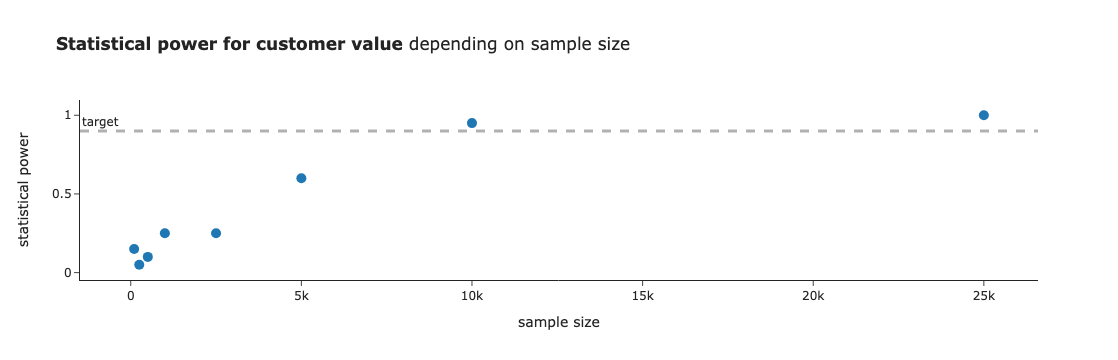

In [107]:
fig = px.scatter(x = val_lowres_sim_stats_df.sample_size, y = val_lowres_sim_stats_df.successful_experiment,
                title = '<b>Statistical power for customer value</b> depending on sample size',
                labels = {'y': 'statistical power', 'x': 'sample size'})
fig.update_traces(marker=dict(size=10))
fig.add_hline(
    y=0.9, line_width=3, line_dash="dash", 
    line_color='black', annotation_text="target", 
    annotation_position="top left"
)

In [108]:
tmp_dfs = []
for sample_size in [5000, 7500, 10000, 12500, 15000, 17500, 20000]:
    print('Simulation for sample size = %d' % sample_size)
    tmp_dfs.append(
        run_simulations_for_value(before_df, sample_size = sample_size, effect_size = 20,
                              boot_iters = 1000, confidence_level = 0.95, num_simulations = 100)
    )

val_midres_sim_df = pd.concat(tmp_dfs)

Simulation for sample size = 5000


100%|████████████████████████████████████████████████████████████████████| 100/100 [04:42<00:00,  2.83s/it]


Simulation for sample size = 7500


100%|████████████████████████████████████████████████████████████████████| 100/100 [05:06<00:00,  3.06s/it]


Simulation for sample size = 10000


100%|████████████████████████████████████████████████████████████████████| 100/100 [05:42<00:00,  3.43s/it]


Simulation for sample size = 12500


100%|████████████████████████████████████████████████████████████████████| 100/100 [07:01<00:00,  4.21s/it]


Simulation for sample size = 15000


100%|████████████████████████████████████████████████████████████████████| 100/100 [07:16<00:00,  4.37s/it]


Simulation for sample size = 17500


100%|████████████████████████████████████████████████████████████████████| 100/100 [16:35<00:00,  9.95s/it]


Simulation for sample size = 20000


100%|████████████████████████████████████████████████████████████████████| 100/100 [18:14<00:00, 10.95s/it]


In [114]:
val_midres_sim_df['successful_experiment'] = val_midres_sim_df.ci_lower.map(
  lambda x: 1 if x > 0 else 0)
val_midres_sim_stats_df = val_midres_sim_df.groupby(['sample_size', 'effect_size'], as_index = False).aggregate(
    {
        'successful_experiment': 'mean',
        'experiment_id': 'count'
    }
)
val_midres_sim_stats_df

,sample_size,effect_size,successful_experiment,experiment_id
0,5000,20,0.49,100
1,7500,20,0.75,100
2,10000,20,0.88,100
3,12500,20,0.93,100
4,15000,20,0.97,100
5,17500,20,0.99,100
6,20000,20,0.98,100


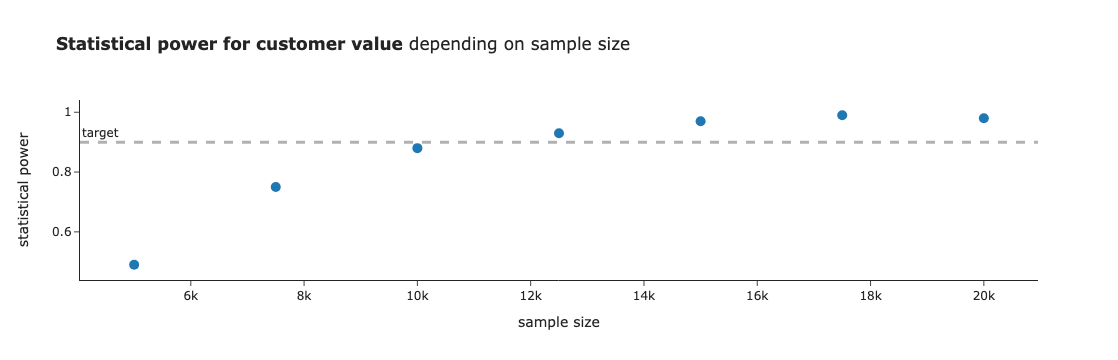

In [115]:
fig = px.scatter(x = val_midres_sim_stats_df.sample_size, y = val_midres_sim_stats_df.successful_experiment,
                title = '<b>Statistical power for customer value</b> depending on sample size',
                labels = {'y': 'statistical power', 'x': 'sample size'})
fig.update_traces(marker=dict(size=10))
fig.add_hline(
    y=0.9, line_width=3, line_dash="dash", 
    line_color='black', annotation_text="target", 
    annotation_position="top left"
)

In [111]:
tmp_dfs = []
for sample_size in [10000, 12500, 15000]:
    print('Simulation for sample size = %d' % sample_size)
    tmp_dfs.append(
        run_simulations_for_value(before_df, sample_size = sample_size, effect_size = 20,
                              boot_iters = 1000, confidence_level = 0.95, num_simulations = 500)
    )

val_highres_sim_df = pd.concat(tmp_dfs)

Simulation for sample size = 10000


100%|████████████████████████████████████████████████████████████████████| 500/500 [45:04<00:00,  5.41s/it]


Simulation for sample size = 12500


100%|████████████████████████████████████████████████████████████████████| 500/500 [34:34<00:00,  4.15s/it]


Simulation for sample size = 15000


100%|████████████████████████████████████████████████████████████████████| 500/500 [32:50<00:00,  3.94s/it]


In [116]:
val_highres_sim_df = high_lowres_sim_df

In [117]:
val_highres_sim_df['successful_experiment'] = val_highres_sim_df.ci_lower.map(
  lambda x: 1 if x > 0 else 0)
val_highres_sim_stats_df = val_highres_sim_df.groupby(['sample_size', 'effect_size'], as_index = False).aggregate(
    {
        'successful_experiment': 'mean',
        'experiment_id': 'count'
    }
)
val_highres_sim_stats_df

,sample_size,effect_size,successful_experiment,experiment_id
0,10000,20,0.87,500
1,12500,20,0.95,500
2,15000,20,0.96,500


In [124]:
val_sim_stats_df = pd.concat(
    [val_lowres_sim_stats_df, val_midres_sim_stats_df, val_highres_sim_stats_df]
)

In [125]:
val_sim_stats_df.experiment_id = val_sim_stats_df.experiment_id.map(str)

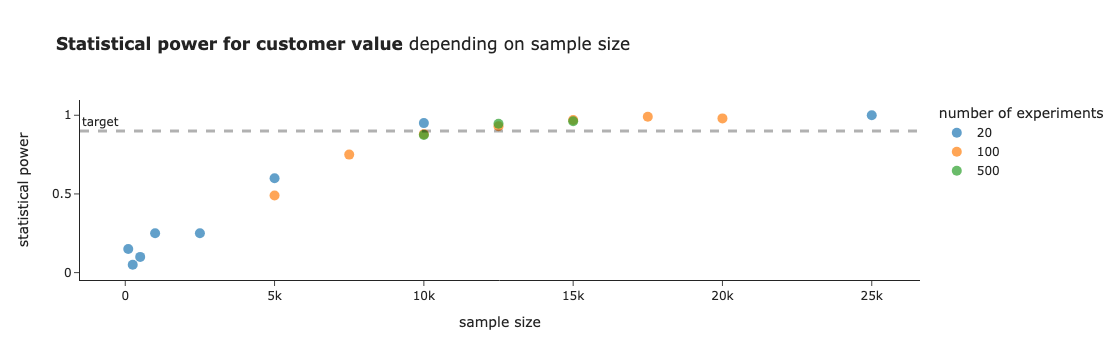

In [128]:
fig = px.scatter(x = val_sim_stats_df.sample_size, y = val_sim_stats_df.successful_experiment,
                 color = val_sim_stats_df.experiment_id,
                title = '<b>Statistical power for customer value</b> depending on sample size',
                labels = {'y': 'statistical power', 'x': 'sample size', 'color': 'number of experiments'})
fig.update_traces(marker=dict(size=10, opacity = 0.7))
fig.add_hline(
    y=0.9, line_width=3, line_dash="dash", 
    line_color='black', annotation_text="target", 
    annotation_position="top left"
)

In [129]:
tmp_dfs = []
for effect_size in [1, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]:
    print('Simulation for effect size = %d' % effect_size)
    tmp_dfs.append(
        run_simulations_for_value(before_df, sample_size = 12500, effect_size = effect_size,
                              boot_iters = 1000, confidence_level = 0.95, num_simulations = 100)
    )

val_effect_size_sim_df = pd.concat(tmp_dfs)

Simulation for effect size = 1


100%|████████████████████████████████████████████████████████████████████| 100/100 [06:09<00:00,  3.69s/it]


Simulation for effect size = 5


100%|████████████████████████████████████████████████████████████████████| 100/100 [06:08<00:00,  3.69s/it]


Simulation for effect size = 10


100%|████████████████████████████████████████████████████████████████████| 100/100 [06:09<00:00,  3.69s/it]


Simulation for effect size = 15


100%|████████████████████████████████████████████████████████████████████| 100/100 [06:09<00:00,  3.70s/it]


Simulation for effect size = 20


100%|████████████████████████████████████████████████████████████████████| 100/100 [06:06<00:00,  3.66s/it]


Simulation for effect size = 25


100%|████████████████████████████████████████████████████████████████████| 100/100 [06:13<00:00,  3.74s/it]


Simulation for effect size = 30


100%|██████████████████████████████████████████████████████████████████| 100/100 [1:19:47<00:00, 47.88s/it]


Simulation for effect size = 40


100%|████████████████████████████████████████████████████████████████████| 100/100 [06:14<00:00,  3.75s/it]


Simulation for effect size = 50


100%|████████████████████████████████████████████████████████████████████| 100/100 [06:09<00:00,  3.69s/it]


Simulation for effect size = 60


100%|████████████████████████████████████████████████████████████████████| 100/100 [06:08<00:00,  3.69s/it]


Simulation for effect size = 70


100%|████████████████████████████████████████████████████████████████████| 100/100 [06:08<00:00,  3.68s/it]


Simulation for effect size = 80


100%|████████████████████████████████████████████████████████████████████| 100/100 [06:07<00:00,  3.68s/it]


Simulation for effect size = 90


100%|████████████████████████████████████████████████████████████████████| 100/100 [06:08<00:00,  3.68s/it]


Simulation for effect size = 100


100%|████████████████████████████████████████████████████████████████████| 100/100 [06:08<00:00,  3.68s/it]


In [130]:
val_effect_size_sim_df['successful_experiment'] = val_effect_size_sim_df.ci_lower.map(
  lambda x: 1 if x > 0 else 0)
val_effect_size_sim_stats_df = val_effect_size_sim_df.groupby(['sample_size', 'effect_size'], as_index = False).aggregate(
    {
        'successful_experiment': 'mean',
        'experiment_id': 'count'
    }
)
val_effect_size_sim_stats_df

,sample_size,effect_size,successful_experiment,experiment_id
0,12500,1,0.02,100
1,12500,5,0.19,100
2,12500,10,0.34,100
3,12500,15,0.77,100
4,12500,20,0.95,100
5,12500,25,0.99,100
6,12500,30,1.00,100
7,12500,40,1.00,100
8,12500,50,1.00,100
9,12500,60,1.00,100


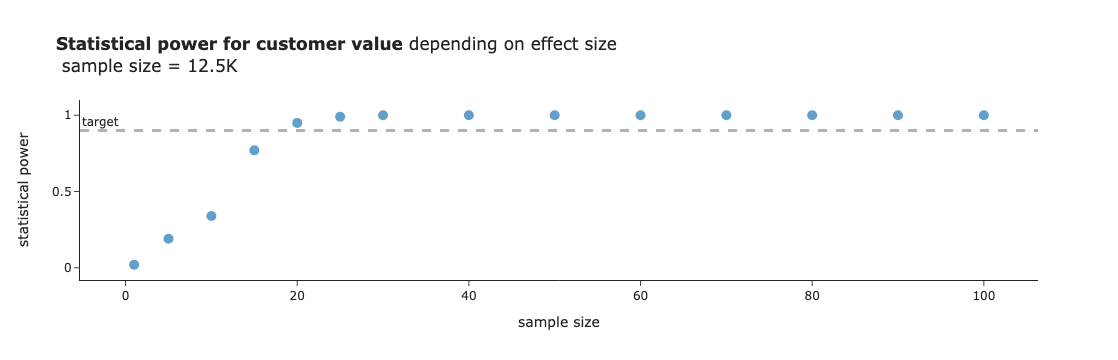

In [132]:
fig = px.scatter(x = val_effect_size_sim_stats_df.effect_size, y = val_effect_size_sim_stats_df.successful_experiment,
                title = '<b>Statistical power for customer value</b> depending on effect size <br> sample size = 12.5K',
                labels = {'y': 'statistical power', 'x': 'sample size', 'color': 'number of experiments'})
fig.update_traces(marker=dict(size=10, opacity = 0.7))
fig.add_hline(
    y=0.9, line_width=3, line_dash="dash", 
    line_color='black', annotation_text="target", 
    annotation_position="top left"
)

#### Retention

In [133]:
# we have a hypothesis that customers with bigger families are more loyal to our brend
base_ret_model = smf.logit('retention ~ num_family_members', data = before_df).fit(disp = 0)
base_ret_model.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,0.3328,0.003,111.282,0.000,0.327,0.339
num_family_members,0.1110,0.001,93.795,0.000,0.109,0.113


In [134]:
np.random.uniform()

0.8725318463685966

In [141]:
import tqdm

def get_sample_for_retention(pop_df, sample_size, effect_size):
    base_ret_model = smf.logit('retention ~ num_family_members', data = pop_df).fit(disp = 0)
    tmp_pop_df = pop_df.copy()
    tmp_pop_df['predicted_retention_proba'] = base_ret_model.predict()
    sample_df = tmp_pop_df.sample(sample_size)
    sample_df['treatment'] = sample_df.index.map(lambda x: 1 if np.random.uniform() > 0.5 else 0)
    sample_df['predicted_retention_proba'] = sample_df['predicted_retention_proba'] + effect_size * sample_df.treatment
    sample_df['retention'] = sample_df.predicted_retention_proba.map(lambda x: 1 if x >= np.random.uniform() else 0)
    return sample_df

def get_ci_for_retention(df, boot_iters, confidence_level):
    tmp_data = []
    
    for iter in range(boot_iters):
        sample_df = df.sample(df.shape[0], replace = True)
        ret_model = smf.logit('retention ~ treatment + num_family_members', data = sample_df).fit(disp = 0)
        tmp_data.append(
            {
                'iteration': iter,
                'coef': ret_model.params['treatment']
            }
        )

    coef_df = pd.DataFrame(tmp_data)
    return coef_df.coef.quantile((1 - confidence_level)/2), coef_df.coef.quantile(1 - (1 - confidence_level)/2)

def run_simulations_for_retention(pop_df, sample_size, effect_size, 
                                  boot_iters, confidence_level, num_simulations):
    tmp_data = []
    
    for sim in tqdm.tqdm(range(num_simulations)):
        sample_df = get_sample_for_retention(pop_df, sample_size, effect_size)
        num_users_treatment = sample_df[sample_df.treatment == 1].shape[0]
        retention_treatment = sample_df[sample_df.treatment == 1].retention.mean()
        num_users_control = sample_df[sample_df.treatment == 0].shape[0]
        retention_control = sample_df[sample_df.treatment == 0].retention.mean()

        ci_lower, ci_upper = get_ci_for_retention(sample_df, boot_iters, confidence_level)

        tmp_data.append(
            {
                'simulation': sim,
                'num_users_treatment': num_users_treatment,
                'retention_treatment': retention_treatment,
                'num_users_control': num_users_control,
                'retention_control': retention_control,
                'sample_size': sample_size,
                'effect_size': effect_size,
                'boot_iters': boot_iters,
                'confidence_level': confidence_level,
                'ci_lower': ci_lower,
                'ci_upper': ci_upper
            }
        )

    return pd.DataFrame(tmp_data)

In [142]:
before_df.retention.mean()

0.642075398039517

In [151]:
# ! pip install tabulate

In [150]:
print(get_sample_for_retention(before_df, 10000, 0.3).groupby('treatment', as_index = False).retention.mean()\
    .to_markdown())

|    |   treatment |   retention |
|---:|------------:|------------:|
|  0 |           0 |    0.640057 |
|  1 |           1 |    0.937648 |


In [156]:
tmp_dfs = []
for sample_size in [1000, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000]:
    print('Simulation for sample size = %d' % sample_size)
    tmp_dfs.append(
        run_simulations_for_retention(before_df, sample_size = sample_size, effect_size = 0.03,
                              boot_iters = 1000, confidence_level = 0.95, num_simulations = 100)
    )

ret_midres_sim_df = pd.concat(tmp_dfs)

In [154]:
ret_midres_sim_df = pd.concat(tmp_dfs)

In [160]:
ret_midres_sim_df['successful_experiment'] = ret_midres_sim_df.ci_lower.map(
  lambda x: 1 if x > 0 else 0)
ret_midres_sim_stats_df = ret_midres_sim_df.groupby(['sample_size', 'effect_size'], as_index = False).aggregate(
    {
        'successful_experiment': 'mean',
        'simulation': 'count'
    }
)
ret_midres_sim_stats_df

,sample_size,effect_size,successful_experiment,simulation
0,1000,0.03,0.17,100
1,2500,0.03,0.35,100
2,5000,0.03,0.64,100
3,7500,0.03,0.83,100
4,10000,0.03,0.84,100
5,12500,0.03,0.96,100
6,15000,0.03,0.98,100
7,17500,0.03,0.97,100


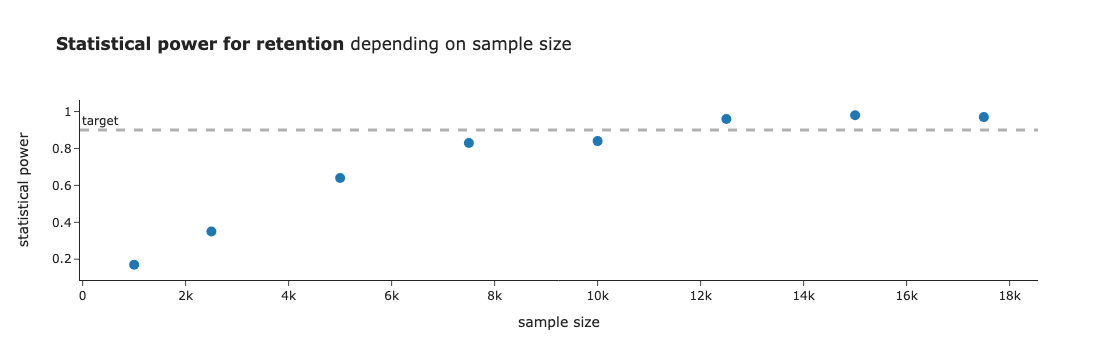

In [163]:
fig = px.scatter(x = ret_midres_sim_stats_df.sample_size, y = ret_midres_sim_stats_df.successful_experiment,
                title = '<b>Statistical power for retention</b> depending on sample size',
                labels = {'y': 'statistical power', 'x': 'sample size'})
fig.update_traces(marker=dict(size=10))
fig.add_hline(
    y=0.9, line_width=3, line_dash="dash", 
    line_color='black', annotation_text="target", 
    annotation_position="top left"
)

### Sample df

In [212]:
experiment_df = after_df.sample(20000)

In [213]:
experiment_df.groupby('treatment').aggregate({'user_id': 'count', 'retention': 'mean'})

,user_id,retention
treatment,,
0,10077,0.65
1,9923,0.68


In [214]:
retention_model = smf.logit('retention ~ treatment + num_family_members', data = experiment_df).fit(disp = 0)
retention_model.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,0.3565,0.036,9.967,0.000,0.286,0.427
treatment,0.1272,0.030,4.226,0.000,0.068,0.186
num_family_members,0.1205,0.013,9.399,0.000,0.095,0.146


In [216]:
get_ci_for_retention(experiment_df, 1000, 0.95)

(0.07206555115931897, 0.1865070596880643)

In [220]:
experiment_df['treatment_eq_1'] = 1
experiment_df['treatment_eq_0'] = 0

In [226]:
experiment_df['retention_proba_treatment'] = retention_model.predict(
    experiment_df[['retention', 'treatment_eq_1', 'num_family_members']].rename(columns = {'treatment_eq_1': 'treatment'}))

experiment_df['retention_proba_control'] = retention_model.predict(
    experiment_df[['retention', 'treatment_eq_0', 'num_family_members']].rename(columns = {'treatment_eq_0': 'treatment'}))

In [228]:
experiment_df['proba_diff'] = experiment_df.retention_proba_treatment - experiment_df.retention_proba_control

In [234]:
round(experiment_df.proba_diff.mean()*100, 2)

2.81

In [215]:
value_model = smf.ols('customer_value ~ treatment + num_family_members + country_avg_annual_earning', data = experiment_df).fit(disp = 0)
value_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-150.0190,6.899,-21.746,0.000,-163.541,-136.497
treatment,25.8451,4.604,5.614,0.000,16.821,34.869
num_family_members,60.1078,1.923,31.264,0.000,56.339,63.876
country_avg_annual_earning,8.2845,0.098,84.170,0.000,8.092,8.477


In [218]:
get_ci_for_value(experiment_df.rename(columns = {'customer_value': 'predicted_value'}), 1000, 0.95)

(16.278936982500163, 34.62688717618102)